### Siapakaan Model 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_15000.csv')
df.head(10)

,content,sentimen
0,komandan rayon militer danramil 03 senen mayor...,negatif
1,jam tangan 11 15 wib sayur mayur dagangan ivan...,negatif
2,polisi menangkap ruslan 46 pemilik gudang kawa...,negatif
3,kepulan asap putih menyeruak pembuangan tpa ra...,negatif
4,polisi mendalami penembakan relawan prabowo gi...,negatif
5,polisi menjerat khoiri 52 pasal berlapis tega ...,negatif
6,korban tewas gaza akibat serangan israel menca...,negatif
7,ketua dpp partai pan zita anjani mengaku 10 ko...,negatif
8,20 negara setuju bergabung koalisi pimpinan am...,negatif
9,cawapres nomor urut 3 menko polhukam mahfud md...,negatif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

#### World Cloud

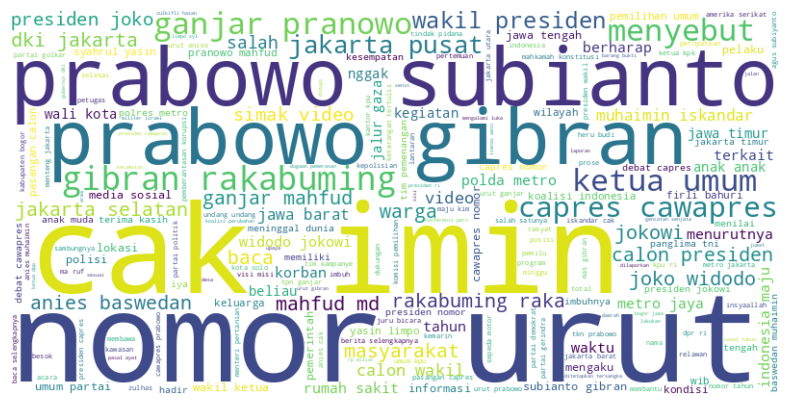

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### LSA

LSA Topics:

Topic #0:
prabowo gibran ganjar presiden mahfud cawapres anies jokowi debat partai

Topic #1:
kpk firli israel syl tersangka korban gaza syahrul bahuri firli bahuri

Topic #2:
israel gaza hamas serangan palestina jalur gaza jalur korban perang tewas

Topic #3:
ganjar imin anies cak cak imin mahfud debat muhaimin kpu ganjar mahfud

Topic #4:
israel gaza kpk firli hamas serangan mahfud ganjar syl debat

Topic #5:
ganjar mahfud jokowi ganjar mahfud pdip pranowo ganjar pranowo megawati mahfud md md

Topic #6:
debat gibran mahfud korban cawapres ganjar kpu pelaku debat cawapres debat capres

Topic #7:
debat tni agus panglima panglima tni jenderal ksad subiyanto agus subiyanto kpu

Topic #8:
mk konstitusi putusan hakim mkmk mahkamah mahkamah konstitusi anwar anwar usman usia

Topic #9:
tni agus panglima gibran panglima tni survei jenderal prabowo gibran jenderal agus agus subiyanto


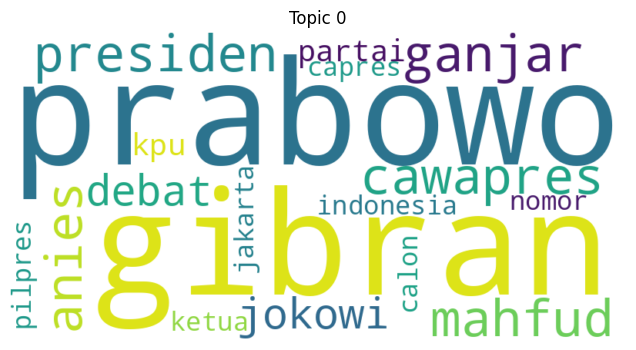

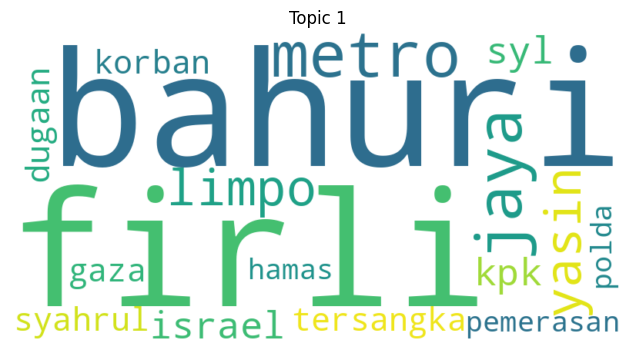

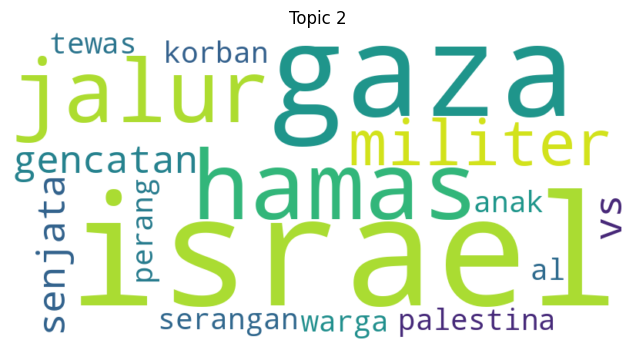

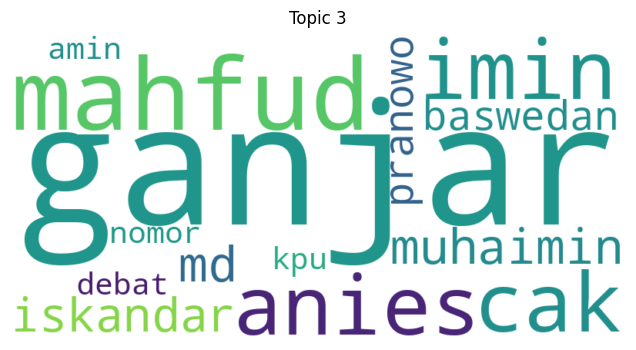

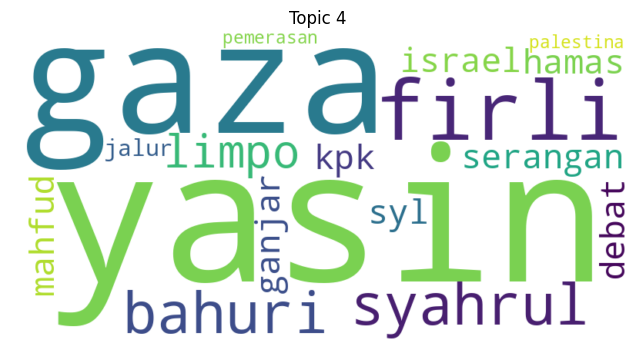

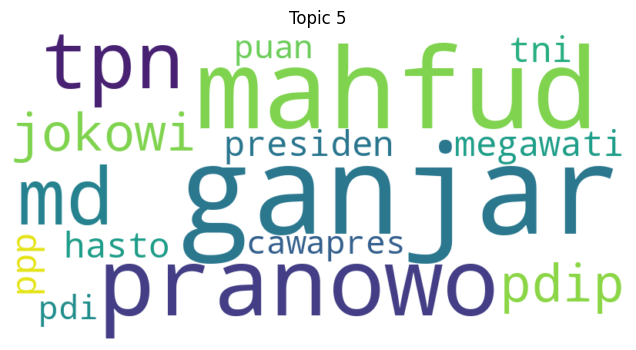

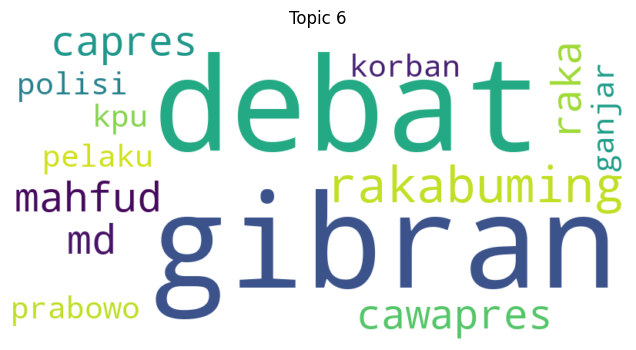

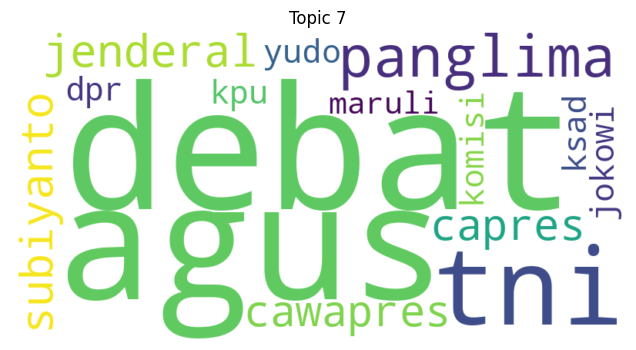

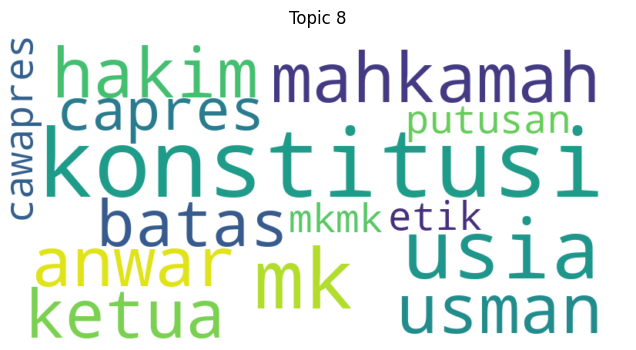

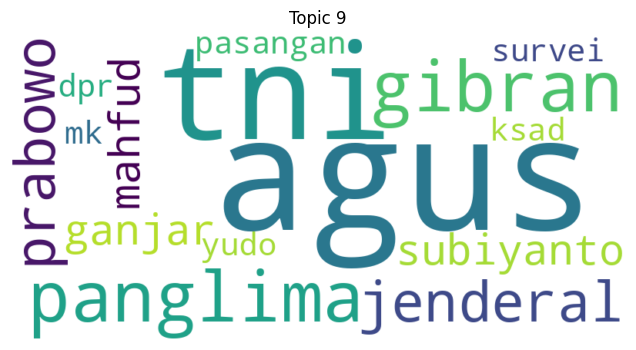

In [10]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define the number of topics
num_topics = 10

# Perform LSA
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_train_features = lsa_model.fit_transform(tfidf_train_features)

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to print the most important words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the most important words for each topic
print("LSA Topics:")
print_top_words(lsa_model, feature_names, 10)

# Generate a word cloud for each topic
for i in range(num_topics):
    # Get the most important words for the topic
    top_words = [feature_names[j] for j in lsa_model.components_[i].argsort()[:-20 - 1:-1]]
    # Join them into a single string
    topic_text = ' '.join(top_words)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)
    # Display the generated image
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic ' + str(i))
    plt.axis('off')
    plt.show()


### Naiye Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [12]:
# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train_features, y_train_encoded)

# Predict on test data
y_pred = nb_classifier.predict(tfidf_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred) * 100
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test_encoded, y_pred, average='weighted') * 100
print("F1 Score:", f1)

Accuracy: 66.93333333333334
F1 Score: 66.46823588958438


#### Model SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Fit the model
svm_model.fit(tfidf_train_features, y_train_encoded)

# Predict on test data
y_pred = svm_model.predict(tfidf_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.7386666666666667
F1 Score: 0.7381326509617783
